In [ ]:
# default_exp sparse.granularity

# Granularity

>  What block of parameter to remove in a neural network ?

In [ ]:
#all_slow

In [ ]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.basics import *
from fastcore.imports import *

In [ ]:
#hide
from fasterai.sparse.sparsifier import Sparsifier
from fasterai.sparse.criteria import *
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Conv2d Pruning

In [ ]:
#export
_granularities_Conv2d = {'weight':0, 'shared_weight':1, 'channel':2, 'column':3, 'row':4, 'kernel':(3,4), 'filter':(2,3,4), 'shared_channel':(1,2), 'shared_column': (1,3), 'shared_row': (1,4), 'vertical_slice': (2,3), 'horizontal_slice': (2,4), 'shared_vertical_slice': (1,2,3), 'shared_horizontal_slice': (1,2,4), 'shared_kernel': (1,3,4), 'layer':(1,2,3,4)}

A `Conv2d` layer possess a 4d-tensor as weights. This means that there exist many ways of removing blocks from it.

### 0-D blocks

The most simple way is to remove individual weights, i.e. remove 0-dimension blocks

In [ ]:
#hide
def get_pruned_conv(dim):
    conv = nn.Conv2d(3, 16, 7, 1)
    pruned_weights = conv.weight[None].mean(dim=dim, keepdim=True).squeeze(0)
    threshold = torch.quantile(pruned_weights.view(-1), 0.8)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    plot_kernels(conv.weight.data.mul_(mask))

In [ ]:
#hide
def plot_kernels(weights, save=None):
    kernels = abs(weights)
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    plt.figure(figsize=(10,10))
    img = make_grid(kernels, nrow=8, padding=1, pad_value=1)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

### 0-D Blocks

In the case of convolution filters, removing 0-D elements is equivalent to removing individual weights. 

* `weight` granularity

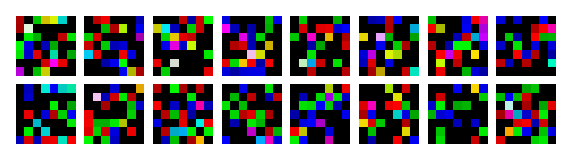

In [ ]:
get_pruned_conv(0)

### 1-D Blocks

1-D blocks of elements is equivalent to removing vectors from the convolution filters. There are several ways to chose the vectors, that will be represented below.

* `shared_weight`: this granularity is very particular as it removes individual weights from a filter, but with a pattern that is shared across all filters.

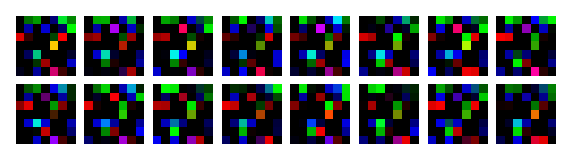

In [ ]:
get_pruned_conv(1)

* `channel`: remove vector of weights along the channel axis.

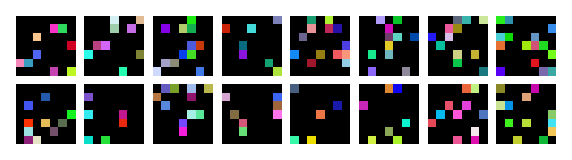

In [ ]:
get_pruned_conv(2)

* `column`: remove vector of weights along the height axis.

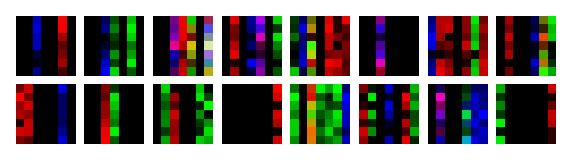

In [ ]:
get_pruned_conv(3)

* `row`: remove vector of weights along the width axis.

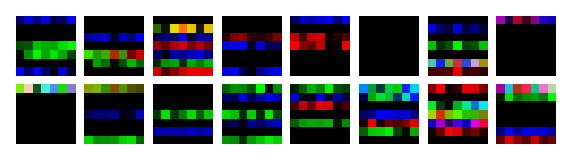

In [ ]:
get_pruned_conv(4)

### 2-D Blocks

* `shared_channel`: remove vector of weight along the channel axis, but with a pattern that is shared across all filters.

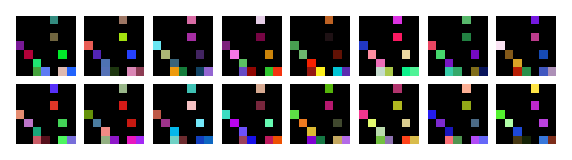

In [ ]:
get_pruned_conv((1,2))

* `shared_column`: remove vector of weight along the height axis, but with a pattern that is shared across all filters.

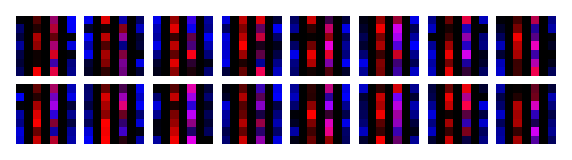

In [ ]:
get_pruned_conv((1,3))

* `shared_row`: remove vector of weight along the width axis, but with a pattern that is shared across all filters.

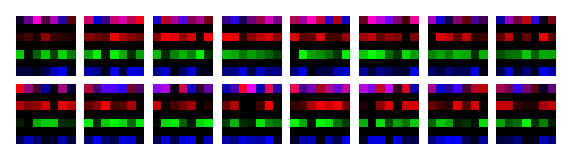

In [ ]:
get_pruned_conv((1,4))

* `vertical_slice`: remove vertical slices of weight along the height axis.

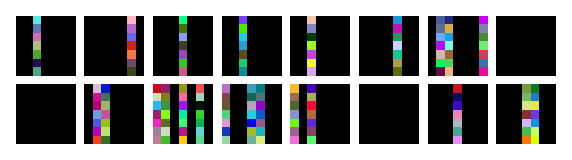

In [ ]:
get_pruned_conv((2,3))

* `horizontal_slice`: remove vertical slices of weight along the width axis.

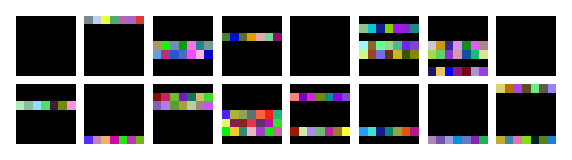

In [ ]:
get_pruned_conv((2,4))

* `kernel`: remove kernels of from the convolution filters.

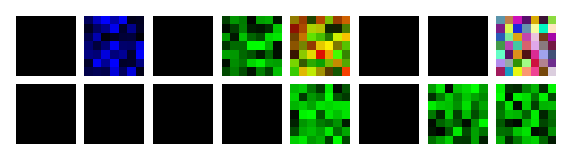

In [ ]:
get_pruned_conv((3,4))

### 3-D Blocks

* `shared_vertical_slice`: remove vertical slices of weight along the height axis, with a pattern that is shared across all filters.

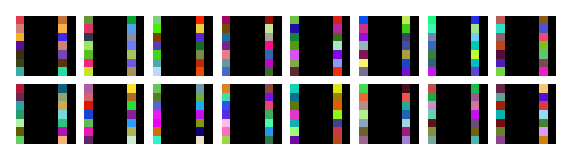

In [ ]:
get_pruned_conv((1,2,3))

* `shared_horizontal_slice`: remove horizontal slices of weight along the width axis, with a pattern that is shared across all filters.

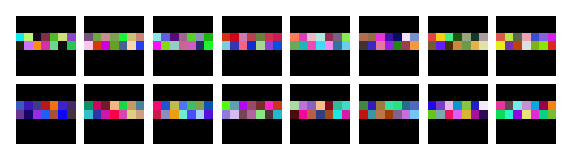

In [ ]:
get_pruned_conv((1,2,4))

* `shared_kernel`: remove kernels of weight from the convolution filters, with a pattern that is shared across all filters.

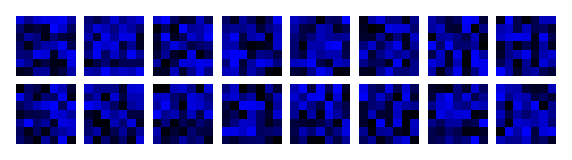

In [ ]:
get_pruned_conv((1,3,4))

* `filter`: remove entire filters.

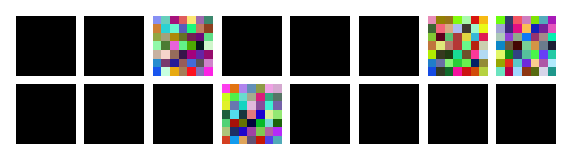

In [ ]:
get_pruned_conv((2,3,4))

## Linear Pruning

In [ ]:
#export
_granularities_Linear = {'weight':0, 'column':1, 'row':2, 'layer':(1,2)}

In [ ]:
#hide
def get_pruned_linear(dim):
    lin = nn.Linear(256,128)
    pruned_weights = lin.weight[None].mean(dim=dim, keepdim=True).squeeze(0)
    threshold = torch.quantile(pruned_weights.view(-1), 0.8)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    plot_kernels(lin.weight.data.mul_(mask))

In [ ]:
#hide
def plot_matrix(weights, save=None):
    kernels = abs(weights)
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    plt.figure(figsize=(10,10))
    img = make_grid(kernels, nrow=8, padding=1, pad_value=1)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

### 0-D Blocks

As for the convolution filters, weights from a Linear layer can be removed independently.

* `weight`: remove individual weights.

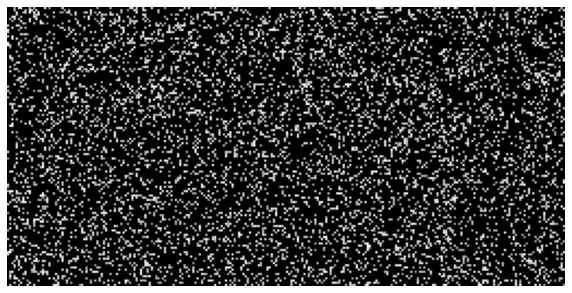

In [ ]:
get_pruned_linear(0)

## 1-D Blocks

* `column`: remove column of weight, which corresponds to removing input neurons.

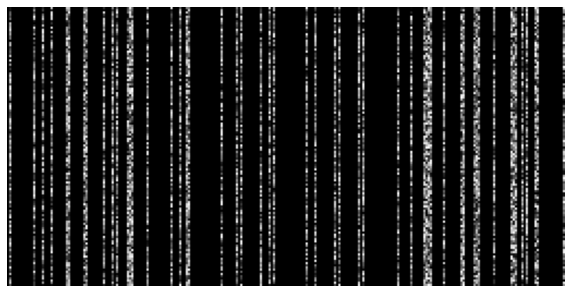

In [ ]:
get_pruned_linear(1)

* `row`: remove rows of weight, which corresponds to removing output neurons.

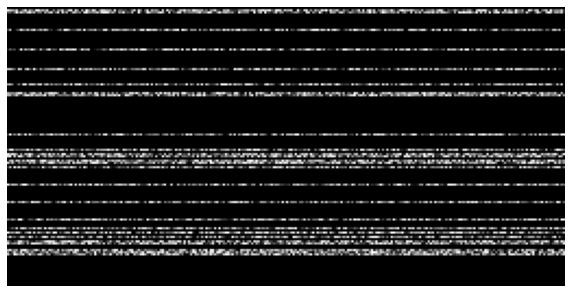

In [ ]:
get_pruned_linear(2)

## Transformer Pruning

> Note: This is an experimental part of the library

In [ ]:
#export
_granularities_Conv1D = {'weight':0, 'column':1, 'row':2, 'layer':(1,2)}

In [ ]:
#export
granularities = {'Conv2d': _granularities_Conv2d, 'Linear': _granularities_Linear, 'Conv1D': _granularities_Conv1D }